# Coursework 1: 

## **Predicting gestational age at scan and birth for neonates from the developing Human Connectome Project**

In this coursework we ask you to put into practice the foundational theoretical skills and practical PyTorch coding techniques we taught you in weeks 1-4. This will test your understanding of how to design, create and train effective deep architectures in future, as well as how to perform appropriate pre-processing, data augmentation. optmisation and visualisation to maximise the accuracy, generalisability and interpretability of your models. We will expect you to:

1. Create custom DataSets from which you sample (separate train and validation) batches at random using a DataLoader
2. Design and implement appropriate augmentations so as to maximise the performance of your model on a left out set
4. Create a custom ResNet (with preactivation - [He 2016](https://arxiv.org/abs/1603.05027)) in order to perform perform regression. 
5. Write a training loop and optimise
6. Visualise the outputs of your network to evaluate whether your network is learning appropriate features.
 
**Deadline for the coursework is 5pm 28/02/2021.**


## **The Data**

The cerebral cortex is a thin layer of tissue at the outer surface of the brain, where most cells responsible for higher-order cognitive processing are found. The creation and maturation of these cells develops rapidly during fetal and early neonatal development (in the weeks and months just before and after birth), which leads to cortical folding and dramatic changes in the observed intensities of T1 and T2-weighted Magnetic Resonance Imaging (MRI). In this exercise you will use different MRI-derived metrics of cortical maturation to **predict the gestational age at scan _and_ at birth of babies scanned as part of the Developing Human Connectome Project** (dHCP, Makropoulos et al 2018). 

Since age at scan is a much stronger phenotype (easier to predict) we have set the notebook up such that you design and optimise your network for prediction of age at scan. Then modify/refine it for the task of age at birth. To achieve optimal performance on age at birth you will need to deconfound age at scan from the age at birth experiment

We will use metrics of cortical thickness, cortical curvature, cortical myelination and sulcal depth generated from mesh models of the cortical surface. While we will explore Geometric Deep Learning (for direct analysis of surface imaging data) in the last lecture of  course. Right now you will work with files which have been projected to 2D via the sphere:

<img src="https://drive.google.com/uc?id=1GLwUBYMQdOJPo3qLzzh518eoEcvlTOHj" alt="Drawing" style="width: 100px;"/>

Here A, shows the original cortical maps (for 3 of the 4 modalities), B shows the maps as you will view them with MatplotLib and C shows the type of regression result you might expect for prediction of age at scan if you trained your network long enough.


## **Getting started**

First mount your Google Drive and import all necessary packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
!pip3 install SimpleITK
!pip3 install imageio
!pip3 install scikit-image
!pip3 install seaborn


import SimpleITK as sitk
import time
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import torchvision
import scipy.misc
import imageio
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
from torch.utils.data.sampler import SubsetRandomSampler
from skimage.transform import resize
from torchvision import transforms, utils

import time
import seaborn as sns

# initialize network weights as a gaussian
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

save_path = 'results'

if not os.path.exists(save_path):
    os.makedirs(save_path)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 31.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Accessing and loading the data set**

The data is available from this shared [GOOGLE DRIVE LINK](https://drive.google.com/drive/folders/1zqIXXtDTCF0M90C8q4eS809a0Zqxmtyh?usp=sharing). Once you access the link the folder should be accessible from your Google Drive. Note, it is possible to access data directly from a shared google drive/files so long as you first add it to your drive.

To do this:

- log into google drive and accept the invitation to share the folder/file. You should see the folder 'coursework1-data' under "shared with me" on the left side.
- Click on the folder / file so that they turn blue and are highlighted (do not enter the folder)
- Click on the three vertical dots and click "Add to My Drive" or "Add a Shortcut to Drive".

Labels are available [here](https://drive.google.com/file/d/1_W0ZW_VpfrIm6dxAXRf80iVErhE5qczn/view?usp=sharing) as a 2 column (pickled) pandas dataframe that defines 1) the subject id (`subj_id`) and 2) the target label: their gestational age at scan (`scan_pma`) **Download these labels and add them to your Drive** in the location indicated by the below path

#### **Now verify that you can successfully load and visualise the image files**

Try running the cell below to check everything is working. Take a clear note of the shape - it will require editing into the format PyTorch expects.

subject meta data subj_id        0
scan_pma    44.0
Name: 0, dtype: object
example shapea  (240, 320, 4)


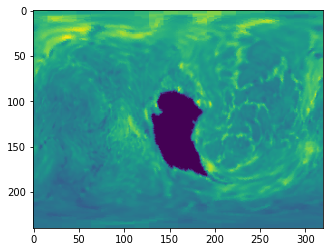

In [3]:
### cell/for testing file input/output/visualisation

dirname='/content/drive/MyDrive/coursework1-data-2022-pma'

example_im=np.load(os.path.join(dirname,'2D_projection_L_sub-0.npy'))

meta_path='/content/drive/MyDrive/meta_2022_pma.pkl'
label_df=pd.read_pickle(meta_path)

plt.imshow(example_im[:,:,0])

print('subject meta data', label_df.iloc[0])
print('example shapea ', example_im.shape)  

# NOTE PyTorch is going to expect your data batches to have shape BxCxHxW 
# (Batch,Channels, Height, Width)!

In [4]:
# Print the label df
label_df.head()

,subj_id,scan_pma
0,0,44.0
1,1,42.57
2,2,42.57
3,3,42.0
4,4,40.71



# **Exercise 1 Create a Custom DataSet and DataLoaders (15 Marks)**

### **Ex 1.1 Create data set class (8 marks)**

Complete a custom Dataset for this exercise. Make sure to return both images and their corresponding labels and return image tensors of the correct shape.


In [5]:
# Create Dataset Class: this returns the image and the label
class GADataset(torch.utils.data.Dataset):
    def __init__(self, data_folder_location, labels_df):

        self.data_folder_location = data_folder_location
        self.labels_df = labels_df
        return

    def __len__(self):
        return len(os.listdir(self.data_folder_location))

    def __getitem__(self, idx):
        image_name = str(self.data_folder_location) + '/2D_projection_L_sub-' + str(idx) + '.npy'
        label = self.labels_df['scan_pma'].iloc[idx]

        image = np.load(image_name)

        image = transforms.ToTensor()(image)
        label = torch.tensor(label)
        sample = image, label

        return sample


**Ex 1.2 Test Dataset and create separate dataloaders for train and validation. (7 marks)**
-  print data set length (1 mark) 
- Create a Train Dataloader that samples from the first 425 subjects; batch size = 32 (2 marks)
- Create a Validation Dataloader that samples from the remaining 51 subjects; batch size = whole validation set (2 marks)
-  return one batch from the train dataloader; print shape _and_ plot ( 2 mark)



Data set length: 476
image batch shape:, torch.Size([32, 4, 240, 320])
label batch shape:, torch.Size([32])


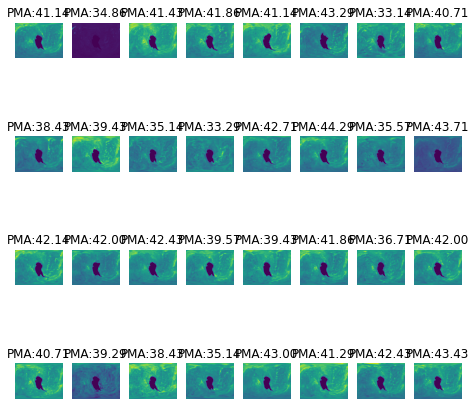

In [6]:
# STUDENTS CODE - CREATE DATASET INSTANCE AND SEPARATE DATALOADERS FOR VALIDATION AND TEST

my_data = GADataset(dirname, label_df)
print(f'Data set length: {my_data.__len__()}') # print data set length

# Devide the data into training and tersting
train = torch.utils.data.Subset(my_data, range(425))
validation = torch.utils.data.Subset(my_data, range(425, 476))

# Create Dataloaders
train_data = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
validation_data = torch.utils.data.DataLoader(validation, batch_size=validation.__len__(), shuffle=False)

im_batch, lab_batch = next(iter(train_data)) # get a batch
print(f'image batch shape:, {im_batch.shape}')
print(f'label batch shape:, {lab_batch.shape}')

rows = 4
cols = 8

fig = plt.figure(figsize=(8, 8))
plt.tight_layout


for i in range(32):
    fig.add_subplot(rows, cols, i+1)
    plt.title(f'PMA:{lab_batch[i]:.2f}')
    plt.imshow(im_batch[i][0,:,:].cpu())
    plt.axis('off')

**Total Ex. 2: 15 marks**

# **Exercise 2 - Create a pre-activation ResNet (15 marks)**



## **Ex 2.1 create a pre-activation residual block class (5 marks)**

Modify the residual block `ResidualBlock` class from the `3.1.Architectures_2021.ipynb` notebook to implement preactivation residual blocks following the implementation in the 2016 paper [He 2016](https://arxiv.org/abs/1603.05027)) 

**Note** if you are unable to implement this you may use the residual class from the tutorial notebook in order to complete the rest of the coursework

In [7]:
# Students implement 2016 residual block
# Note that this is the 2016 architecture

class ResidualBlock(nn.Module):

    def __init__(self, channels1,channels2,res_stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1=nn.Conv2d(channels1,channels2,kernel_size=1,stride=1, bias=False)
        self.bn1=nn.BatchNorm2d(channels2)
        self.conv2=nn.Conv2d(channels2,channels2,kernel_size=3,stride=res_stride,padding=1, bias=False)
        self.bn2=nn.BatchNorm2d(channels2)
        self.conv3=nn.Conv2d(channels2,channels2,kernel_size=1,stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(channels2)

        if res_stride != 1 or channels2 != channels1:
            self.shortcut=nn.Sequential(nn.Conv2d(channels1,channels2,kernel_size=1,stride=res_stride, bias=False),
                                        nn.BatchNorm2d(channels2))
            
        else:
            self.shortcut=nn.Sequential()
            

    def forward(self, x):
        out=self.conv1(x)
        out=self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)

        out+=self.shortcut(x)

        out = F.relu(out)

        return out

## **Ex 2.2. Implement a ResNet class (10 marks)**

Create a ResNet class such that reflects the basic structure of a typical ResNet; this includes : 

1. An initial strided convolutional layer with stride=2 and padding=1 (1 mark)
2. Any number of residual block layers (3 marks)
3. Linear layer to return output (for single output regression) (2 mark)
5. Implement these correctly in the forward function (4 marks)

**Hints**
 -  you can take inspiration from the original ResNet paper [He et al 2015](https://arxiv.org/pdf/1512.03385.pdf) for building the architecture.
 - While creating your ResNet class, try thinking about the complexity of your network in the context of the task your trying to solve and the size of your dataset.  


In [8]:
# STUDENTS CODE - CREATE RESNET NETWORK CLASS

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_strides, num_features):
        super(ResNet, self).__init__()
        self.in_channels = num_features[0]
        self.conv1 = nn.Conv2d(4, num_features[0], kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features[0])
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, num_blocks, num_strides[0], num_features[0])
        self.layer2 = self.make_layer(block, num_blocks, num_strides[1], num_features[1])
        self.layer3 = self.make_layer(block, num_blocks, num_strides[2], num_features[2])
        self.layer4 = self.make_layer(block, num_blocks, num_strides[3], num_features[3])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_features[3], 1)

    def make_layer(self, block, num_blocks, stride, out_channels):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for i in range(num_blocks - 1):
            layers.append(block(out_channels, out_channels, res_stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

**Total for section: 15**

# **Exercise 3 Train for prediction of postmenstrual age at scan (15 marks)**

Now that you have a basic network the first thing we will do is ask you to train your network to predict age at scan.

Age at scan is a strong phenotype since the appearance of babies brains change dramatically over the first few weeks of life. This experiment can therefore be seen as a baseline from which to optimise performance of your network prior to training on birth age (which is more difficult)


## **Ex 3.1 Initialise network, optimiser and loss function (5 marks)**
- print model to check the architecture (one option is to pip install and use the library torchsummary)


In [9]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

cuda


In [12]:
# STUDENTS CODE - CREATE INSTANCE OF NETWORK & PASS TO NETWORK
model = ResNet(block=ResidualBlock, num_blocks=3, num_strides=[1,2,2,2], num_features=[64,128,256,512]).to(device)
my_tensor = torch.randn(32, 4, 240, 320)
y = model(my_tensor.to(device))

!pip install torchsummary
from torchsummary import summary
summary(model, (4, 240, 320))
# CREATE LOSS OBJECT AND OPTIMISER
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 120, 160]           2,304
       BatchNorm2d-2         [-1, 64, 120, 160]             128
              ReLU-3         [-1, 64, 120, 160]               0
            Conv2d-4         [-1, 64, 120, 160]           4,096
       BatchNorm2d-5         [-1, 64, 120, 160]             128
            Conv2d-6         [-1, 64, 120, 160]          36,864
       BatchNorm2d-7         [-1, 64, 120, 160]             128
            Conv2d-8         [-1, 64, 120, 160]           4,096
       BatchNorm2d-9         [-1, 64, 120, 160]             128
    ResidualBlock-10         [-1, 64, 120, 160]               0
           Conv2d-11         [-1, 64, 120, 160]           4,096
      BatchNorm2d-12         [-1, 64, 120, 160]             128
    


## **Ex 3.2: Implement training and validation loops** (10 marks)

- Implement training loop (5 marks)
- Implement validation loop (3 marks)
- Plot validation and training loss (2 marks)

Train your network for 10 epochs. You should aim at a validation error around/below 1.0 and a smoothly decreasing loss curve.

In [13]:
# STUDENTS CODE - TRAIN AND VALIDATE over 10 epochs
NUM_EPOCHS = 10
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    train_loss = 0
    for i, data in enumerate(train_data):
        X, y = data
        X, y = X.to(device), y.to(device)
        model.train()
        y_pred = model(X.float())
        loss = loss_fn(torch.squeeze(y_pred), y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_data)
    train_losses.append(train_loss)

    val_loss = 0
    model.eval()
    with torch.inference_mode():
        for i, data in enumerate(validation_data):
            X_val, y_val = data
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_pred = model(X_val.float())
            val_loss += loss_fn(torch.squeeze(val_pred), y_val)
        val_loss /= len(validation_data)
        val_losses.append(val_loss)
    
    print( f"Epoch: {epoch+1}, Train loss: {train_loss:.4f} | Validation loss: {val_loss:.4f}")

print(f'Final Train RMSE: {np.sqrt(train_loss.cpu().detach())} | Final Validation RMSE: {np.sqrt(val_loss.cpu())}')

Epoch: 1, Train loss: 949.2266 | Validation loss: 691.1675
Epoch: 2, Train loss: 308.3378 | Validation loss: 206.4988
Epoch: 3, Train loss: 63.0620 | Validation loss: 30.0414
Epoch: 4, Train loss: 5.9591 | Validation loss: 6.4722
Epoch: 5, Train loss: 3.6502 | Validation loss: 8.4472
Epoch: 6, Train loss: 2.0538 | Validation loss: 12.7991
Epoch: 7, Train loss: 1.8444 | Validation loss: 5.5708
Epoch: 8, Train loss: 2.0727 | Validation loss: 4.8947
Epoch: 9, Train loss: 1.4822 | Validation loss: 14.0109
Epoch: 10, Train loss: 1.7479 | Validation loss: 2.9136
Final Train RMSE: 1.322087287902832 | Final Validation RMSE: 1.7069411277770996


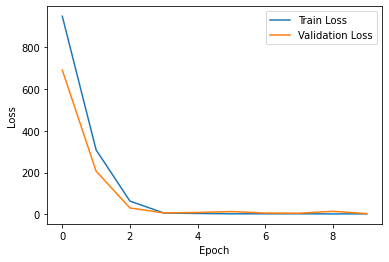

In [14]:
plt.plot(torch.tensor(train_losses, device='cpu'), label="Train Loss")
plt.plot(torch.tensor(val_losses, device='cpu'), label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Total for section: 15** 

# **Exercise 4. Design Custom Augmentations & Optimise (20 marks)**

Now retrain but this time implement custom augmentations for your training data set

### **Example**

An example of class generating a class for image resizing is given below. It includes an `__init__` constructor (which sets parameters) and a `__call__`  function (which takes as input data and performs a transformation) 

```
class ResizeImage(object):
    
       def __init__(self, image_size):
            self.image_size = image_size

       def __call__(self, data):
            if len(self.image_size) == 2:
                image_resized = resize(data, (self.image_size[0], self.image_size[1]),
                                       anti_aliasing=True)
            else:
                image_resized = resize(data, (self.image_size[0], self.image_size[1], self.image_size[2]),
                                       anti_aliasing=True)

            return image_resized
```
You may also want to reference the official [PyTorch tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms)

We ask you to create two custom transform classes: 

1. to add Gaussian random noise; 
2. to simulate elastic deformations. 


## **Exercise 4.1 add a custom class for addition of Gaussian noise (4 marks)**

- Create a class which adds random gaussian noise to each datapoint of the image tensor (2 mark)
- set standard deviation as a tunable parameter (1 mark)
- test it on an example image 
and plot result (1 marks)

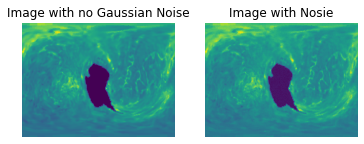

In [10]:
# STUDENTS CODE - CREATE GAUSSIAN TRANSFORM CLASS
class GaussianNoiseTransform:
    def __init__(self, std):
        self.std = std

    def __call__(self, img):
        noise = torch.randn(img.size()) * self.std
        return img + noise

# STUDENTS CODE - TEST TRANSFORM ON DATA EXAMPLE

transform = transforms.Compose([GaussianNoiseTransform(0.1)])

fig, axs = plt.subplots(1, 2)
axs[0].imshow(im_batch[0][0,:,:].cpu())
axs[0].set_title('Image with no Gaussian Noise')
axs[0].axis('off')
axs[1].imshow(transform(im_batch[0][0,:,:].cpu()))
axs[1].set_title('Image with Nosie')
axs[1].axis('off')
plt.show()

## **Exercise Task 4.2 implement elastic augmentation**  (7 marks)

Implement a class for elastic augmentation

**hint** if you chose to adapt the example from week 3 (3_2_Dealing_with_Medical_Data_Notebook_solutions.ipynb) then make sure to account for the fact that this is a multi-channel 2D image rather than a single channel 3D image

Marks 
-  Implementation of a class for elastic 2D augmentation ( 5 marks)
-  set the displacement magnitude and deformation smoothness as a tunable parameter (1) 
-  apply and plot for a test image (1 marks)


In [11]:
def create_elastic_deformation(image, num_controlpoints, sigma):
    """
    We need to parameterise our b-spline transform
    The transform will depend on such variables as image size and sigma
    Sigma modulates the strength of the transformation
    The number of control points controls the granularity of our transform
    """
    # Create an instance of a SimpleITK image of the same size as our image
    itkimg = sitk.GetImageFromArray(np.zeros(image.shape))
    # This parameter is just a list with the number of control points per image dimensions
    trans_from_domain_mesh_size = [num_controlpoints] * itkimg.GetDimension()
    # We initialise the transform here: Passing the image size and the control point specifications
    bspline_transformation = sitk.BSplineTransformInitializer(itkimg, trans_from_domain_mesh_size)
    # Isolate the transform parameters: the bspline control points and spline coefficients
    params = np.asarray(bspline_transformation.GetParameters(), dtype=float)
    # Let's initialise the transform by randomly displacing each control point by a random distance (magnitude sigma)
    bspline_transformation.SetParameters(tuple(params))
    return bspline_transformation


def apply_elastic_deformation(image, num_controlpoints=5, sigma=1):
    # We need to choose an interpolation method for our transformed image, let's just go with b-spline
    resampler = sitk.ResampleImageFilter()
    resampler.SetInterpolator(sitk.sitkBSpline)
    # Let's convert our image to an sitk image
    sitk_image = sitk.GetImageFromArray(image)
    # Specify the image to be transformed: This is the reference image
    resampler.SetReferenceImage(sitk_image)
    resampler.SetDefaultPixelValue(0)
    # Initialise the transform
    bspline_transform = create_elastic_deformation(image, num_controlpoints, sigma)
    # Set the transform in the initialiser
    resampler.SetTransform(bspline_transform)
    # Carry out the resampling according to the transform and the resampling method
    out_img_sitk = resampler.Execute(sitk_image)
    # Convert the image back into a python array
    out_img = sitk.GetArrayFromImage(out_img_sitk)
    return out_img.reshape(image.shape)

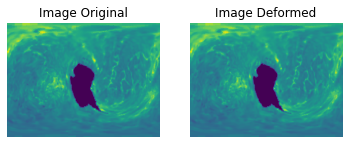

In [12]:
# STUDENTS CODE - CREATE ELASTIC TRANSFORM CLASS
class ElasticAugmentationTransform:
    def __init__(self, num_controlpoints, sigma):
        self.num_controlpoints = num_controlpoints
        self.sigma = sigma

    def __call__(self, img):
        return apply_elastic_deformation(img, self.num_controlpoints, self.sigma)

# STUDENTS CODE - TEST TRANSFORM ON DATA EXAMPLE

transform2 = transforms.Compose([ElasticAugmentationTransform(5, 1)])

fig, axs = plt.subplots(1, 2)
axs[0].imshow(im_batch[0][0,:,:].cpu())
axs[0].set_title('Image Original')
axs[0].axis('off')
axs[1].imshow(transform2(im_batch[0][0,:,:].cpu()))
axs[1].set_title('Image Deformed')
axs[1].axis('off')
plt.show()

## **Exercise 4.3  Compose the transform and re-train (4 marks)**

- Compose Gaussian and Elastic transforms (if you have them) into a single transform object using `torchvision.transforms.Compose` (1 mark)
- Regenerate train and validation datasets and dataloader; this time implementing augmentation for training only (2 marks)
- retrain (1 mark)



In [13]:
# STUDENTS CODE - COMPOSE TRANSFORM

transform = torchvision.transforms.Compose([GaussianNoiseTransform(0.1), ElasticAugmentationTransform(5, 1)])

# STUDENTS CODE - RETRAIN NETWORK THIS TIME WITH TRAIN TIME AUGMENTATION

train = torch.utils.data.Subset(my_data, range(425))
train.transform=transform # Implement augmentation for training only
validation = torch.utils.data.Subset(my_data, range(425, 476))

train_data = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
validation_data = torch.utils.data.DataLoader(validation, batch_size=validation.__len__(), shuffle=False)

In [19]:
# Retraining with applied transforms

model = ResNet(block=ResidualBlock, num_blocks=3, num_strides=[1,2,2,2], num_features=[64,128,256,512]).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

NUM_EPOCHS = 10
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    train_loss = 0
    for i, data in enumerate(train_data):
        X, y = data
        X, y = X.to(device), y.to(device)
        model.train()
        y_pred = model(X.float())
        loss = loss_fn(torch.squeeze(y_pred), y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_data)
    train_losses.append(train_loss)

    val_loss = 0
    model.eval()
    with torch.inference_mode():
        for i, data in enumerate(validation_data):
            X_val, y_val = data
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_pred = model(X_val.float())
            val_loss += loss_fn(torch.squeeze(val_pred), y_val)
        val_loss /= len(validation_data)
        val_losses.append(val_loss)
    
    print( f"Epoch: {epoch+1}, Train loss: {train_loss:.4f} | Validation loss: {val_loss:.4f}")

print(f'Final Train RMSE: {np.sqrt(train_loss.cpu().detach())} | Final Validation RMSE: {np.sqrt(val_loss.cpu())}')

Epoch: 1, Train loss: 901.6190 | Validation loss: 737.1939
Epoch: 2, Train loss: 274.2410 | Validation loss: 208.5109
Epoch: 3, Train loss: 51.9294 | Validation loss: 12.1795
Epoch: 4, Train loss: 4.4071 | Validation loss: 4.3087
Epoch: 5, Train loss: 2.7628 | Validation loss: 11.4356
Epoch: 6, Train loss: 3.0377 | Validation loss: 3.1759
Epoch: 7, Train loss: 1.5591 | Validation loss: 7.6237
Epoch: 8, Train loss: 1.3397 | Validation loss: 3.8359
Epoch: 9, Train loss: 1.2595 | Validation loss: 2.8115
Epoch: 10, Train loss: 1.1427 | Validation loss: 0.8900
Final Train RMSE: 1.068985104560852 | Final Validation RMSE: 0.9434105753898621


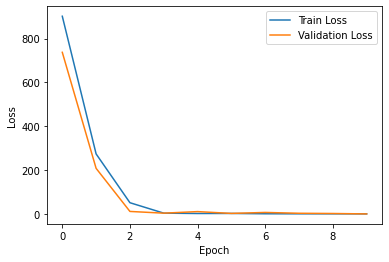

In [20]:
plt.plot(torch.tensor(train_losses, device='cpu'), label="Train Loss")
plt.plot(torch.tensor(val_losses, device='cpu'), label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## **Exercise 4.4: Optimise (5 marks)**

Try optimising the network further.

Explain your strategy. Describe how different strategies impact the training. Try to get an error below 0.9. 


In [26]:
# STUDENTS CODE - OPTIMISE NETWORK

transform = torchvision.transforms.Compose([GaussianNoiseTransform(0.3), ElasticAugmentationTransform(20, 5)])

train = torch.utils.data.Subset(my_data, range(425))
train.transform=transform
validation = torch.utils.data.Subset(my_data, range(425, 476))

train_data = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
validation_data = torch.utils.data.DataLoader(validation, batch_size=validation.__len__(), shuffle=False)

model = ResNet(block=ResidualBlock, num_blocks=4, num_strides=[1,2,2,2], num_features=[64,128,256,512]).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

NUM_EPOCHS = 15
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    train_loss = 0
    for i, data in enumerate(train_data):
        X, y = data
        X, y = X.to(device), y.to(device)
        model.train()
        y_pred = model(X.float())
        loss = loss_fn(torch.squeeze(y_pred), y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_data)
    train_losses.append(train_loss)

    val_loss = 0
    model.eval()
    with torch.inference_mode():
        for i, data in enumerate(validation_data):
            X_val, y_val = data
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_pred = model(X_val.float())
            val_loss += loss_fn(torch.squeeze(val_pred), y_val)
        val_loss /= len(validation_data)
        val_losses.append(val_loss)
    
    print( f"Epoch: {epoch+1}, Train loss: {train_loss:.4f} | Validation loss: {val_loss:.4f}")

print(f'Final Train RMSE: {np.sqrt(train_loss.cpu().detach())} | Final Validation RMSE: {np.sqrt(val_loss.cpu())}')

Epoch: 1, Train loss: 890.1595 | Validation loss: 363.1765
Epoch: 2, Train loss: 193.2933 | Validation loss: 71.0174
Epoch: 3, Train loss: 16.9822 | Validation loss: 5.2938
Epoch: 4, Train loss: 3.3583 | Validation loss: 45.9199
Epoch: 5, Train loss: 2.2732 | Validation loss: 14.2479
Epoch: 6, Train loss: 1.4833 | Validation loss: 9.9602
Epoch: 7, Train loss: 1.3700 | Validation loss: 2.2226
Epoch: 8, Train loss: 1.4538 | Validation loss: 2.3825
Epoch: 9, Train loss: 1.1688 | Validation loss: 2.1432
Epoch: 10, Train loss: 1.1609 | Validation loss: 7.0341
Epoch: 11, Train loss: 1.2352 | Validation loss: 3.8861
Epoch: 12, Train loss: 1.3960 | Validation loss: 1.7915
Epoch: 13, Train loss: 1.6148 | Validation loss: 1.7508
Epoch: 14, Train loss: 1.1005 | Validation loss: 3.4356
Epoch: 15, Train loss: 1.2029 | Validation loss: 0.8005
Final Train RMSE: 1.0967756509780884 | Final Validation RMSE: 0.8946868777275085


In [27]:
torch.save(model.state_dict(), '/content/drive/MyDrive/optimised_model.pt')

In [14]:
# Note: the model was saved so it can be loaded so it does not have to be retraiend
loaded_model = ResNet(block=ResidualBlock, num_blocks=4, num_strides=[1,2,2,2], num_features=[64,128,256,512]).to(device)
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/optimised_model.pt'))
loaded_model.eval()

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

*STUDENTS: For the optimisation process more Gaussian noise was introduced to the training images by increasing the std in the transform, this way, the network can learn to ignore data with more noise. Also, the displacement magnitude and the smoothness parameters in the elastic augmentation were modified so the network can learn from more distorted data. Finally, as there was no massive overfitting when comparing the train and validation RMSE, the number of epochs was increased to 15, this lead to obtain a training RMSE close than 1 and a validation RMSE less than 0.9.*

**Total for section:total: 10**

# **Exercise 6: Birth Age Prediction (25 marks)**

In this last part of the coursework, you will try to solve a more difficult prediction task: prediction of the **birth age** of babies scanned as part of the Developing Human Connectome Project. For this, you will be using a new subset of the dhcp data with the same metrics as previously. 

Additionally, you will explore the problem of dealing with confounds in medical imaging; the task of birth age prediction being highly impacted by the apparence of the scan and thus the postmenstrual age at scan. Therefore, to improve predictions of birth age you will try to incorporate that information in the training process. 

Another key point to make here is that the data is imbalanced - while not a classification problem this can be addressed by noting that samples are much fewer for babies with birth ages below 37 weeks.

## **Ex 6.1 Create a new pipeline for Gestational Age predictions and train a network (5 marks)**

Data for gestational age prediction an be found [here](https://drive.google.com/drive/folders/1cJry-yrgsuVYajkmpBtbzz7zvCpSrfv4?usp=sharing). Labels can be found [here](https://drive.google.com/file/d/1HMrszbvJhUjLgZprKCpbOJQB92PBP2kl/view?usp=sharing). 

- First adapt your existing dataset class to return the image with GA as the label
- Create dataloaders for training and validation - with the first 411 subjects for training and the 51 remaining for valiation. 
- Train a model for 10 epochs. Observe the differences in performance compared to the previous task of gestational age at scan prediction

subj_id         0
scan_ga     40.14
scan_pma     44.0
Name: 0, dtype: object


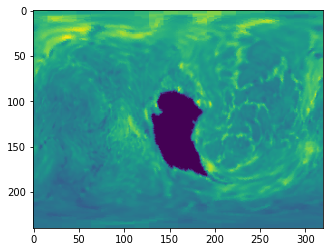

In [18]:
dirname='/content/drive/MyDrive/coursework1-data-2022-ga'

example_im=np.load(os.path.join(dirname,'2D_projection_L_sub-0.npy'))

meta_path='/content/drive/MyDrive/meta_2022_ga.pkl'
label_df=pd.read_pickle(meta_path)

plt.imshow(example_im[:,:,0])

print(label_df.iloc[0])

In [19]:
# print the label df
label_df.head()

,subj_id,scan_ga,scan_pma
0,0,40.14,44.0
1,1,41.14,42.57
2,2,37.71,42.57
3,3,41.86,42.0
4,4,40.00,40.71


In [20]:
# STUDENTS CODE -  create Datasets/Dataloaders for GA predictions
# This data set return age at birth as a label
class GADataset2(torch.utils.data.Dataset):
    def __init__(self, data_folder_location, labels_df):

        self.data_folder_location = data_folder_location
        self.labels_df = labels_df
        return

    def __len__(self):
        return len(os.listdir(self.data_folder_location))

    def __getitem__(self, idx):
        image_name = str(self.data_folder_location) + '/2D_projection_L_sub-' + str(idx) + '.npy'
        label = self.labels_df['scan_ga'].iloc[idx]

        image = np.load(image_name)

        image = transforms.ToTensor()(image)
        label = torch.tensor(label)
        sample = image, label.float()

        return sample

my_data = GADataset2(dirname, label_df)
print(f'Data set length: {my_data.__len__()}')

train = torch.utils.data.Subset(my_data, range(411))
validation = torch.utils.data.Subset(my_data, range(411, 462))

train_data = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
validation_data = torch.utils.data.DataLoader(validation, batch_size=validation.__len__(), shuffle=False)

Data set length: 462


In [15]:
# STUDENTS CODE -  train to verify this is working

model_ga = ResNet(block=ResidualBlock, num_blocks=3, num_strides=[1,2,2,2], num_features=[64,128,256,512]).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_ga.parameters(), lr=0.001)

NUM_EPOCHS = 10
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    for i, data in enumerate(train_data):
        X, y = data
        X, y = X.to(device), y.to(device)
        model_ga.train()
        y_pred = model_ga(X.float())
        loss = loss_fn(torch.squeeze(y_pred), y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_data)
    train_losses.append(train_loss)

    val_loss = 0.0
    model_ga.eval()
    with torch.inference_mode():
        for i, data in enumerate(validation_data):
            X_val, y_val = data
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_pred = model_ga(X_val.float())
            val_loss += loss_fn(torch.squeeze(val_pred), y_val)
        val_loss /= len(validation_data)
        val_losses.append(val_loss)
    
    print( f"Epoch: {epoch+1}, Train loss: {train_loss:.4f} | Validation loss: {val_loss:.4f}")

print(f'Final Train RMSE: {np.sqrt(train_loss.cpu().detach())} | Final Validation RMSE: {np.sqrt(val_loss.cpu())}')

Epoch: 1, Train loss: 636.5435 | Validation loss: 351.4261
Epoch: 2, Train loss: 58.4659 | Validation loss: 6.9800
Epoch: 3, Train loss: 9.9511 | Validation loss: 15.0976
Epoch: 4, Train loss: 9.5475 | Validation loss: 12.5506
Epoch: 5, Train loss: 9.9799 | Validation loss: 16.6743
Epoch: 6, Train loss: 9.4351 | Validation loss: 14.0979
Epoch: 7, Train loss: 9.3751 | Validation loss: 7.3841
Epoch: 8, Train loss: 8.8794 | Validation loss: 8.9331
Epoch: 9, Train loss: 8.7847 | Validation loss: 9.8356
Epoch: 10, Train loss: 8.1450 | Validation loss: 8.3070
Final Train RMSE: 2.8539443016052246 | Final Validation RMSE: 2.882179021835327


## **Ex 6.2 Create a new Dataset for Gestational Age predictions with confounds ( 5 marks)**

- Adapt the dataset to return 3 elements **[image, (birth age, scan age)]**
- Regenerate train and validation DataLoaders
- consider ways to address class imbalance

In [21]:
# STUDENTS CODE -  adapt Dataset to return birth age and scan age

class GADataset3(torch.utils.data.Dataset):
    def __init__(self, data_folder_location, labels_df):

        self.data_folder_location = data_folder_location
        self.labels_df = labels_df
        return

    def __len__(self):
        return len(os.listdir(self.data_folder_location))

    def __getitem__(self, idx):
        image_name = str(self.data_folder_location) + '/2D_projection_L_sub-' + str(idx) + '.npy'
        label = (self.labels_df['scan_ga'].iloc[idx], self.labels_df['scan_pma'].iloc[idx]) # Note that the label here includes birth age and scan age

        image = np.load(image_name)

        image = transforms.ToTensor()(image)
        label = torch.tensor(label)
        sample = image, label

        return sample

my_data = GADataset3(dirname, label_df)
print(f'Data set length: {my_data.__len__()}')

train = torch.utils.data.Subset(my_data, range(411))
validation = torch.utils.data.Subset(my_data, range(411, 462))

train_data = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
validation_data = torch.utils.data.DataLoader(validation, batch_size=validation.__len__(), shuffle=False)

im_batch, lab_batch = next(iter(train_data)) # get a batch
# Print both the image and label shape to see everything worked fine
print(f'image batch shape:, {im_batch.shape}')
print(f'label batch shape:, {lab_batch.shape}')
print(lab_batch[0])

Data set length: 462
image batch shape:, torch.Size([8, 4, 240, 320])
label batch shape:, torch.Size([8, 2])
tensor([40.7100, 42.0000], dtype=torch.float64)


## **Ex 6.3 Edit ResNet to deconfound Gestational Age predictions with age at scan (5 marks)**

Prediction of gestational age at birth is a more difficult task than scan age prediction. Indeed, this task is highly correlated to the PMA at scan. Therefore, to improve GA predictions [Fawaz et al 2021](https://www.biorxiv.org/content/10.1101/2021.12.01.470730v1) incorporated scan age as a confound into the model before the last linear layer (see Figure 4); while [Dahan et al 2021](https://openreview.net/pdf?id=mpp843Bsf-) added that information in the first stages of the architecture (Appendix B.2).

- Modify your ResNet model to incorporate scan age information into the model before the last linear layer. 



In [22]:
# STUDENTS CODE -  adapt ResNet to allow for deconfounding

class ResNet2(nn.Module):
    def __init__(self, block, num_blocks, num_strides, num_features):
        super(ResNet2, self).__init__()
        self.in_channels = num_features[0]
        self.conv1 = nn.Conv2d(4, num_features[0], kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features[0])
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, num_blocks, num_strides[0], num_features[0])
        self.layer2 = self.make_layer(block, num_blocks, num_strides[1], num_features[1])
        self.layer3 = self.make_layer(block, num_blocks, num_strides[2], num_features[2])
        self.layer4 = self.make_layer(block, num_blocks, num_strides[3], num_features[3])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_features[3]+4, 1)

        # This conv2d will take scan_pma and apply a 1x4 conv as in the paper of Fawaz et al 2021
        self.scan_conv = nn.Conv2d(1, 4, 1, 1)

    def make_layer(self, block, num_blocks, stride, out_channels):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for i in range(num_blocks - 1):
            layers.append(block(out_channels, out_channels, res_stride=1))
        return nn.Sequential(*layers)

    def forward(self, x, scan_pma):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        scan_pma = self.scan_conv(scan_pma)
        scan_pma = scan_pma.view(scan_pma.size(0), -1)

        # Concat the data in the last layer with scan_pma
        x = torch.cat((x, scan_pma), 1)
        x = self.fc(x)
        return x

## **Ex 6.4 Train and optimise (10 marks)**

If you are unable to do the deconfounding just optimise for the network you have


In [23]:
# STUDENTS CODE -  train and optimise

# Get the data and apply augmentation (noise and elastic deformastion)
my_data = GADataset3(dirname, label_df)
train = torch.utils.data.Subset(my_data, range(411))
transform = torchvision.transforms.Compose([GaussianNoiseTransform(0.1), ElasticAugmentationTransform(5, 1)])
train.transform = transform
validation = torch.utils.data.Subset(my_data, range(411, 462))
train_data = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
validation_data = torch.utils.data.DataLoader(validation, batch_size=validation.__len__(), shuffle=False)

# Create model with loss_fn and optimizer
model_ga = ResNet2(block=ResidualBlock, num_blocks=3, num_strides=[1,2,2,2], num_features=[64,128,256,512]).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_ga.parameters(), lr=0.001)

NUM_EPOCHS = 15
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    for i, data in enumerate(train_data):
        X, y = data
        X, y = X.to(device), y.to(device)
        model_ga.train()
        y_pred = model_ga(X.float(), y[:,1].unsqueeze(1).unsqueeze(1).unsqueeze(1).float())
        loss = loss_fn(torch.squeeze(y_pred), y[:,0].float())
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_data)
    train_losses.append(train_loss)

    val_loss = 0.0
    model_ga.eval()
    with torch.inference_mode():
        for i, data in enumerate(validation_data):
            X_val, y_val = data
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_pred = model_ga(X_val.float(), y_val[:,1].unsqueeze(1).unsqueeze(1).unsqueeze(1).float())
            val_loss += loss_fn(torch.squeeze(val_pred), y_val[:,0].float())
        val_loss /= len(validation_data)
        val_losses.append(val_loss)
    
    print( f"Epoch: {epoch+1}, Train loss: {train_loss:.4f} | Validation loss: {val_loss:.4f}")

print(f'Final Train RMSE: {np.sqrt(train_loss.cpu().detach())} | Final Validation RMSE: {np.sqrt(val_loss.cpu())}')

Epoch: 1, Train loss: 251.1655 | Validation loss: 11.7332
Epoch: 2, Train loss: 10.2167 | Validation loss: 21.7482
Epoch: 3, Train loss: 10.0281 | Validation loss: 7.7850
Epoch: 4, Train loss: 9.5493 | Validation loss: 8.3628
Epoch: 5, Train loss: 9.2706 | Validation loss: 6.9626
Epoch: 6, Train loss: 9.1534 | Validation loss: 6.4275
Epoch: 7, Train loss: 8.5399 | Validation loss: 7.1117
Epoch: 8, Train loss: 8.7611 | Validation loss: 20.6578
Epoch: 9, Train loss: 7.8512 | Validation loss: 6.8324
Epoch: 10, Train loss: 7.2330 | Validation loss: 10.2563
Epoch: 11, Train loss: 7.3264 | Validation loss: 17.8108
Epoch: 12, Train loss: 7.6824 | Validation loss: 68.6654
Epoch: 13, Train loss: 8.4902 | Validation loss: 19.9497
Epoch: 14, Train loss: 6.6003 | Validation loss: 6.5362
Epoch: 15, Train loss: 6.9695 | Validation loss: 6.4439
Final Train RMSE: 2.639981985092163 | Final Validation RMSE: 2.538475751876831


*STUDENTS: For this network scan_age was confound into the model using the same strategy as Fawal et al. 2021. Also, noise was added to the data so the model knows how to ignore it and elastic augmentation was applied. Finally, the model was train for 15 epochs to reduce error.*

**Total for section: 25**